In [38]:
cd "c:\Users\ecometto001\Documents\Personal\Tesis"

c:\Users\ecometto001\Documents\Personal\Tesis


In [39]:
from cycler import cycler

# Create cycler object. Use any styling from above you please
monochrome = (cycler('color', ['k']) * cycler('linestyle', ['-', '--', ':']) * cycler('marker', ['^',',', '.']))


In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.regression.mixed_linear_model import MixedLM
import warnings
warnings.filterwarnings("ignore")
import random

plt.rcParams["figure.figsize"] = (10, 5)

# sns.set_palette("Greys")
# plt.style.use('dark_background')
random_state=42
random.seed(random_state)

### Leer los datos

In [41]:
tesis = pd.read_csv("Datos/tesis_final.csv")
tesis_basal = tesis[tesis["tpo_programa"] == 0]

In [42]:
tesis.idPaciente.nunique()

560

In [43]:
tesis.head()

,idPaciente,tpo_programa,TAS,Adherencia,Peso,Altura,IMC,DBT,Sexo,Edad,Fuma,ant_HTA,tas_basal,ICC,Adherencia_Acumulada,Adherencia_Total,TAS_Media_Acumulada
0,4026,0,119.000000,1,82.0,152.0,35.0,0.0,0,76.0,0.0,1,116,0.852459,1.0,1.0,119.000000
1,4026,1,127.000000,1,82.0,152.0,35.0,0.0,0,76.0,0.0,1,116,0.852459,1.0,1.0,123.000000
2,4026,2,134.712693,1,82.0,152.0,35.0,0.0,0,76.0,0.0,1,116,0.852459,1.0,1.0,126.904231
3,4026,3,153.000000,1,82.0,152.0,35.0,0.0,0,76.0,0.0,1,116,0.852459,1.0,1.0,133.428173
4,4026,4,188.000000,1,82.0,152.0,35.0,0.0,0,76.0,0.0,1,116,0.852459,1.0,1.0,144.342539


In [44]:
numerical = ["Peso", "Altura", "IMC", "Edad", "tas_basal", "ICC"]
categorical = ["DBT", "Sexo", "Fuma"]

### Análisis de datos de interés

In [45]:
tesis_basal["Sexo"].mean()

0.4928571428571429

In [46]:
tesis_basal["Edad"].mean(), tesis_basal["Edad"].std(), tesis_basal["Edad"].min(), tesis_basal["Edad"].max()

(58.84714548802947, 9.879375164697707, 30.0, 86.0)

In [47]:
tesis_basal["TAS"].mean(), tesis_basal["TAS"].std()

(132.66641356697994, 15.232016406994953)

### Análisis de la respuesta

<AxesSubplot:xlabel='tpo_programa', ylabel='TAS'>

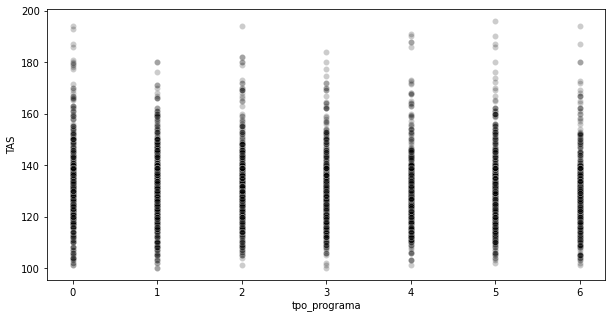

In [48]:
# Scatter plot
fig, ax = plt.subplots(1,1)
ax.set_prop_cycle(monochrome)
sns.scatterplot(x=tesis["tpo_programa"], y=tesis["TAS"], alpha=0.2)

Text(0, 0.5, 'TAS')

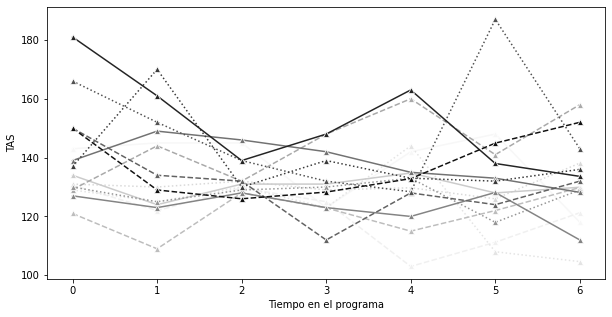

In [49]:
patients = list(tesis["idPaciente"].unique())
k = 15
random.seed(2)
fewer_patients = random.sample(patients, k=k)
plot_df = tesis[tesis["idPaciente"].isin(fewer_patients)]
plot_df = plot_df.pivot_table(values="TAS", index="tpo_programa", columns="idPaciente")
fig, ax = plt.subplots(1,1)
ax.set_prop_cycle(monochrome)
sns.lineplot(data=plot_df, dashes=False, palette="Greys")
plt.legend().set_visible(False)
# plt.title(f"TAS a través del tiempo de {k} pacientes")
plt.xlabel("Tiempo en el programa")
plt.ylabel("TAS")

In [50]:
def jitter(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

Text(0.5, 0, 'Tiempo en el programa')

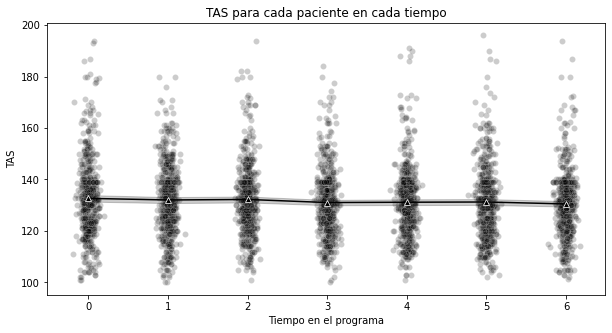

In [51]:
# Mismo gráfico pero con jitter para ver mejor la concentración de los datos
fig, ax = plt.subplots(1,1)
ax.set_prop_cycle(monochrome)
sns.scatterplot(x=jitter(tesis["tpo_programa"]), y=tesis["TAS"], alpha=0.2, palette="Greys")
sns.lineplot(x=tesis["tpo_programa"], y=tesis["TAS"], palette="Greys")
plt.title("TAS para cada paciente en cada tiempo")
plt.xlabel("Tiempo en el programa")

Text(0.5, 1.0, 'Perfil promedio de la TAS a través del tiempo')

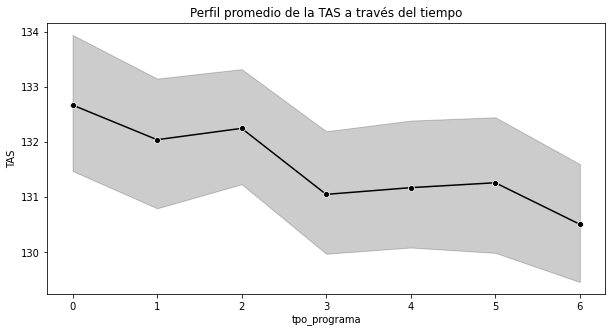

In [52]:
# Gráfico de perfiles promedio
fig, ax = plt.subplots(1,1)
ax.set_prop_cycle(monochrome)
sns.lineplot(x=tesis["tpo_programa"], y=tesis["TAS"], marker="o", palette="Greys")
plt.title("Perfil promedio de la TAS a través del tiempo")

### Análisis descriptivo univariado

Text(0.5, 1.0, 'TAS en el momento basal')

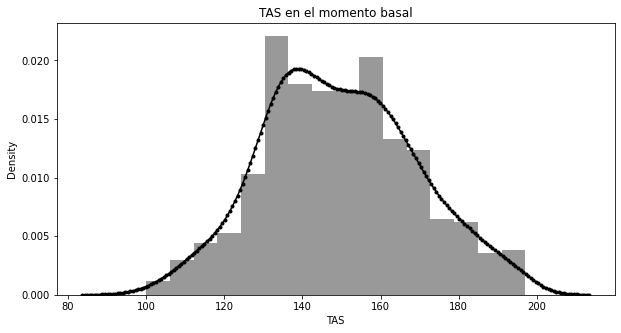

In [53]:
# Variable respuesta
fig, ax = plt.subplots(1,1)
ax.set_prop_cycle(monochrome)
sns.distplot(tesis_basal["tas_basal"])
plt.xlabel("TAS")
plt.title("TAS en el momento basal")

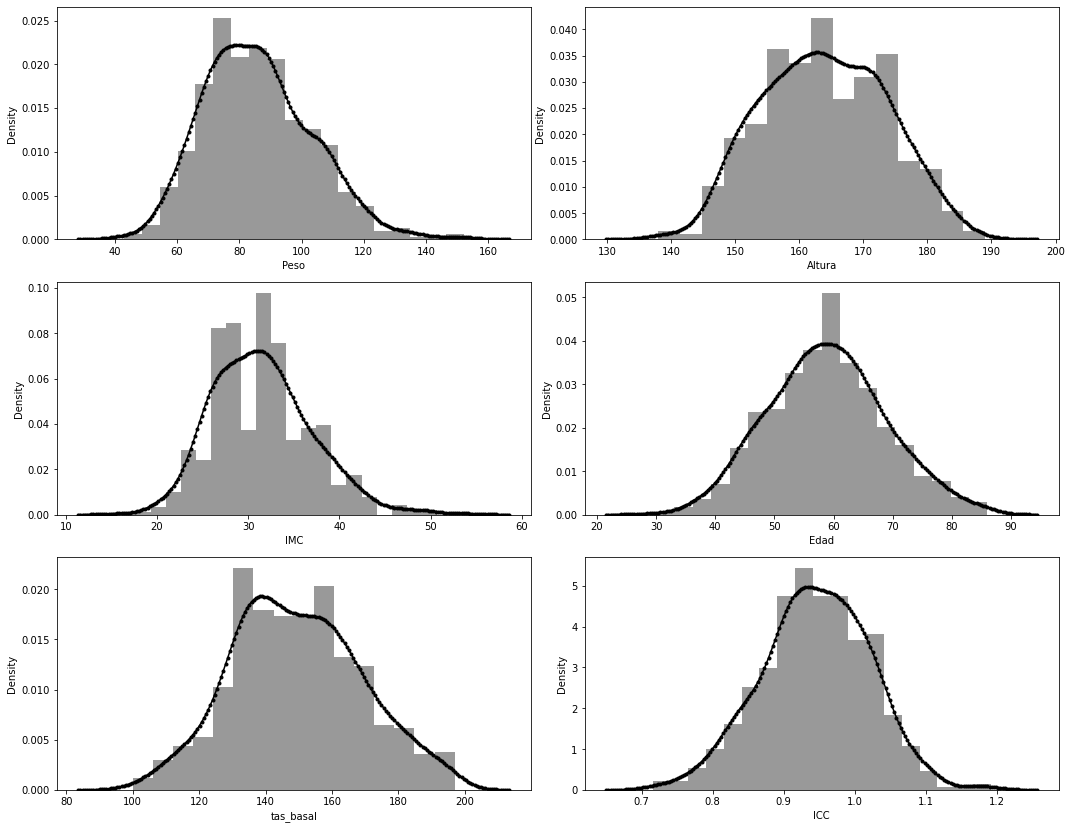

In [54]:
# Plot features
plt.figure(figsize=(15,15))

for i, x in enumerate(numerical):
    axs = plt.subplot(int(len(numerical)/2)+1,2,i+1)
    axs.set_prop_cycle(monochrome)
    dist = sns.distplot(tesis_basal[x])
    dist.axes.set_xlabel(str(x))

plt.tight_layout()
plt.show()

In [55]:
for x in categorical:
    print('*'*50)
    print(tesis_basal[x].value_counts(normalize=True))

**************************************************
0.0    0.859779
1.0    0.140221
Name: DBT, dtype: float64
**************************************************
0    0.507143
1    0.492857
Name: Sexo, dtype: float64
**************************************************
0.0    0.535055
1.0    0.464945
Name: Fuma, dtype: float64


### Análisis descriptivo bivariado

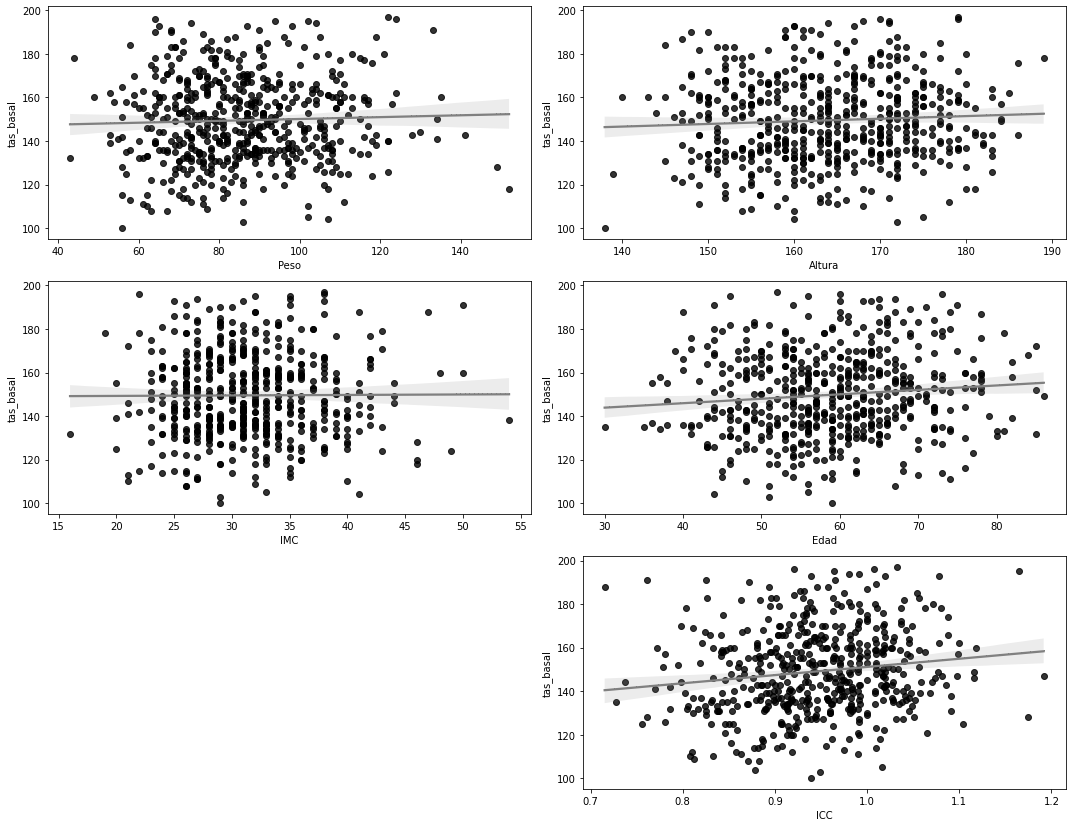

In [56]:
# Covariables numéricas
plt.figure(figsize=(15,15))

for i, x in enumerate(numerical):
    if x == "tas_basal":
        continue
    axs = plt.subplot(int(len(numerical)/2)+1,2,i+1)
    axs.set_prop_cycle(monochrome)
    sns.regplot(x=tesis_basal[x], y=tesis_basal["tas_basal"], line_kws={"color": "grey"})

plt.tight_layout()
plt.show()

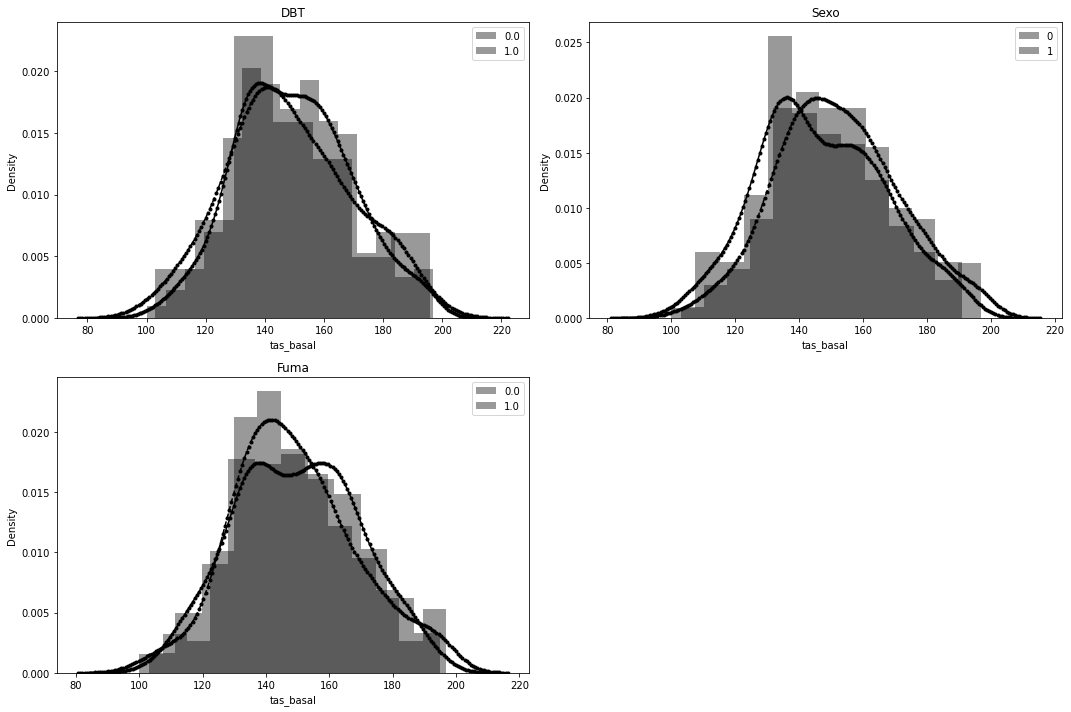

In [57]:
# Covariables categóricas
plt.figure(figsize=(15,10))

for i, x in enumerate(categorical):
    tesis_not_null = tesis_basal[tesis_basal[x].notnull()]
    axs = plt.subplot(int(len(categorical)/2)+1,2,i+1)
    axs.set_prop_cycle(monochrome)
    for value in tesis_not_null[x].unique():
        dist = sns.distplot(tesis_not_null.loc[tesis_not_null[x] == value,"tas_basal"], label=value)
    dist.axes.set_xlabel("tas_basal")
    plt.legend()
    plt.title(str(x))

plt.tight_layout()
plt.show()

### Análisis bivariado a través del tiempo

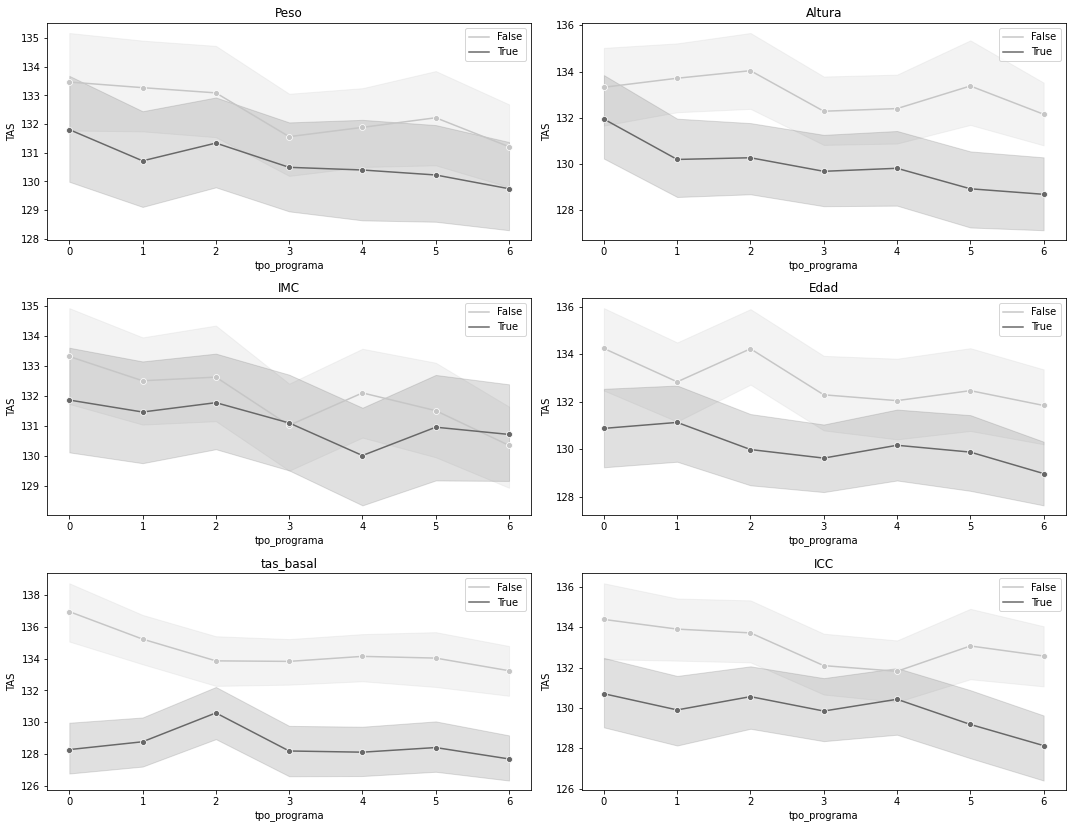

In [58]:
# Covariables numéricas
plt.figure(figsize=(15,15))

for i, x in enumerate(numerical):
    axs = plt.subplot(int(len(numerical)/2)+1,2,i+1)
    hue_mask = tesis[x] < tesis.drop_duplicates(["idPaciente", x])[x].median()
    line = sns.lineplot(x=tesis["tpo_programa"], y=tesis["TAS"], marker="o", hue=hue_mask, palette="Greys")
    plt.legend()
    plt.title(str(x))

plt.tight_layout()
plt.show()

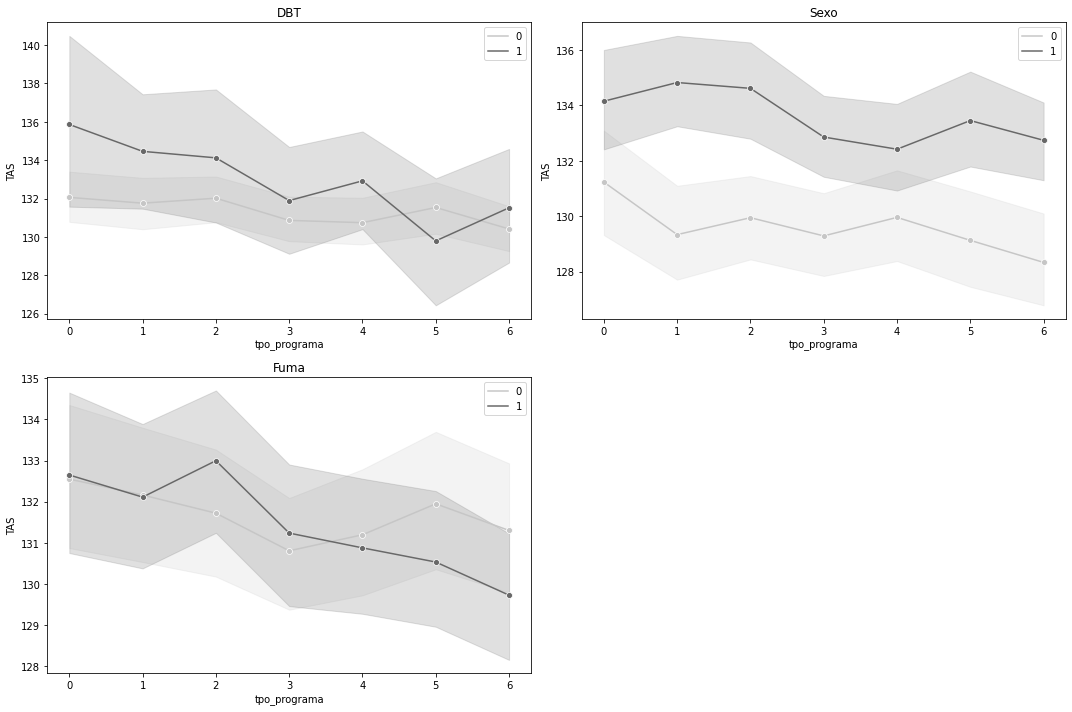

In [59]:
# Covariables categóricas
plt.figure(figsize=(15,10))

for i, x in enumerate(categorical):
    tesis_aux = tesis[tesis[x].notnull()]
    axs = plt.subplot(int(len(categorical)/2)+1,2,i+1)
    line = sns.lineplot(x=tesis_aux["tpo_programa"], y=tesis_aux["TAS"], marker="o", hue=tesis_aux[x].astype("int64"), legend="full", palette="Greys")
    plt.legend()
    plt.title(str(x))

plt.tight_layout()
plt.show()

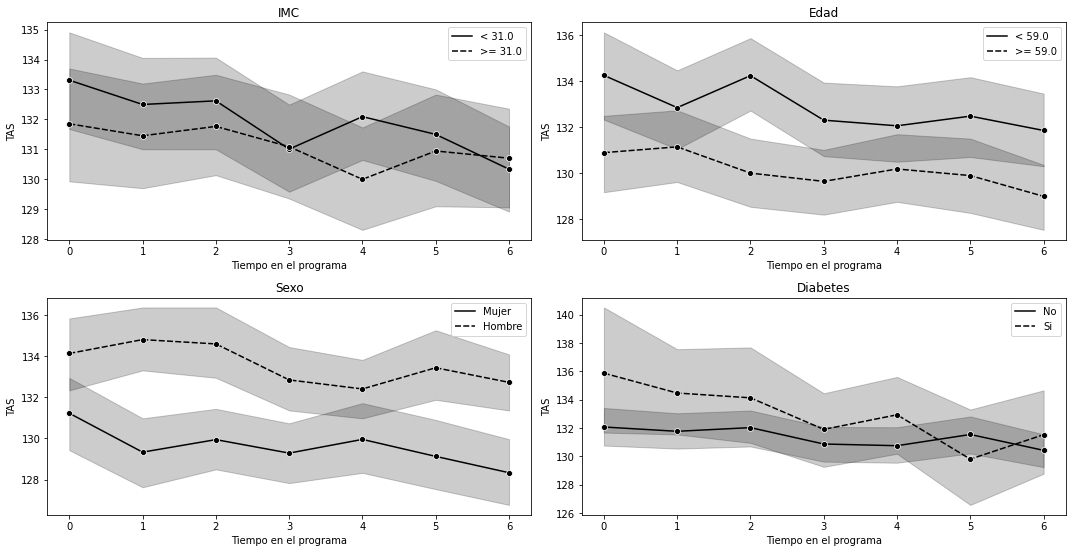

In [60]:
# Covariables importantes
plt.figure(figsize=(15,15))

for i, x in enumerate(["IMC", "Edad", "Sexo", "DBT"]):
    axs = plt.subplot(int(len(numerical)/2)+1,2,i+1)
    if x in ["IMC", "Edad"]:
        median_ = tesis.drop_duplicates(["idPaciente", x])[x].median()
        hue_mask = tesis[x] < median_
        hue_mask = hue_mask.map({True: f">= {median_}", False: f"< {median_}"})
    elif x == "Sexo":
        hue_mask = tesis[x].map({0: "Mujer", 1: "Hombre"})
    elif x == "DBT":
        hue_mask = tesis[x].map({0: "No", 1: "Si"}).rename("Diabetes")
    line = sns.lineplot(x=tesis["tpo_programa"], y=tesis["TAS"], marker="o", hue=hue_mask, style=hue_mask, palette=["black", "black"])
    plt.legend()
    plt.title(str(hue_mask.name))
    plt.xlabel("Tiempo en el programa")

plt.tight_layout()
plt.show()

### Análisis de Morisky

Text(0.5, 1.0, 'Perfiles promedio de la TAS según Adherencia')

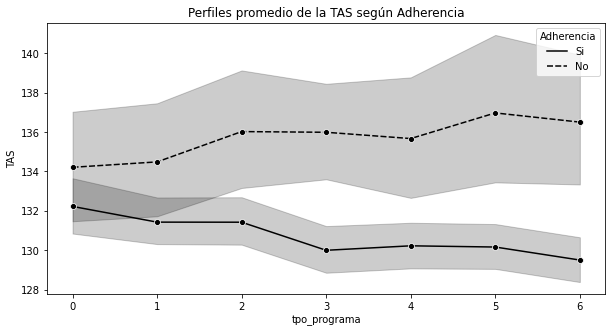

In [61]:
plt.figure(figsize=(10,5))
hue_mask = tesis["Adherencia"].map({0: "No", 1: "Si"})
sns.lineplot(x=tesis["tpo_programa"], y=tesis["TAS"], marker="o", hue=hue_mask, style=hue_mask, palette=["black", "black"])
plt.title("Perfiles promedio de la TAS según Adherencia")

Adherencia_Total mediana:  0.8571428571428571


Text(0.5, 1.0, 'Perfiles promedio de la TAS según proporción de adherencia total del tratamiento')

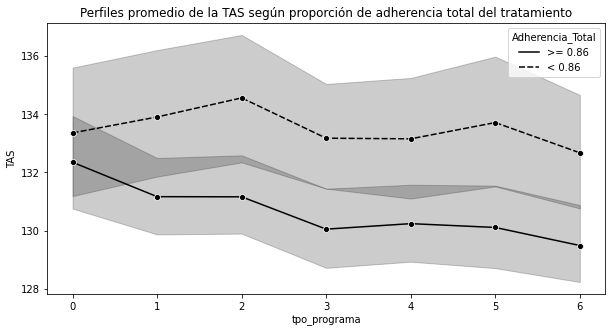

In [80]:
plt.figure(figsize=(10,5))
thresh = tesis.drop_duplicates(["idPaciente", "Adherencia_Total"])["Adherencia_Total"].median()
thresh = thresh
hue_mask = (tesis["Adherencia_Total"] >= thresh).map({False: f"< {round(thresh, 2)}", True: f">= {round(thresh, 2)}"})
sns.lineplot(x=tesis["tpo_programa"], y=tesis["TAS"], marker="o", hue=hue_mask, style=hue_mask, palette=["black", "black"])
print("Adherencia_Total mediana: ", tesis.drop_duplicates(["idPaciente", "Adherencia_Total"])["Adherencia_Total"].median())
plt.title("Perfiles promedio de la TAS según proporción de adherencia total del tratamiento")

<AxesSubplot:xlabel='tpo_programa', ylabel='TAS'>

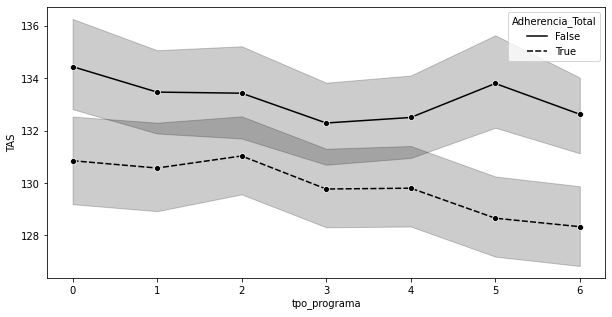

In [63]:
hue_mask = tesis["Adherencia_Total"] == 1
sns.lineplot(x=tesis["tpo_programa"], y=tesis["TAS"], marker="o", hue=hue_mask, style=hue_mask, palette=["black", "black"])

<AxesSubplot:xlabel='tpo_programa', ylabel='Adherencia'>

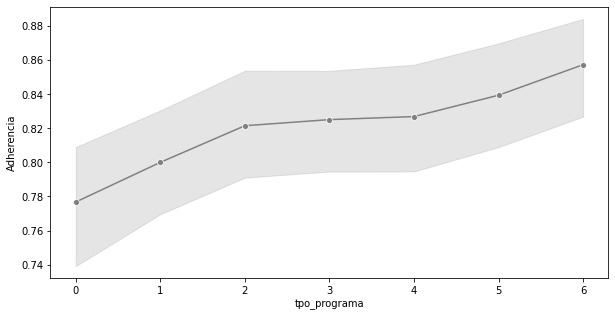

In [64]:
# Porcentaje de adherencia a través del tiempo
sns.lineplot(x=tesis["tpo_programa"], y=tesis["Adherencia"], marker="o", color="Grey")

### Análisis del tiempo

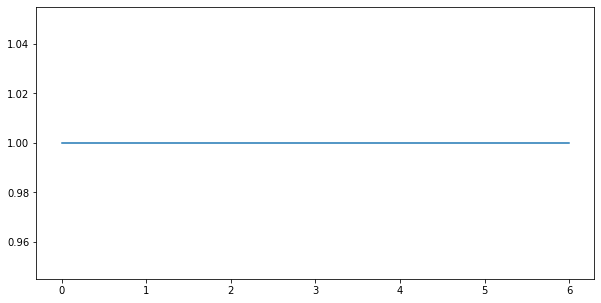

In [65]:
plt.plot(tesis["tpo_programa"].value_counts()/tesis["idPaciente"].nunique())

### Multicolinealidad

<AxesSubplot:>

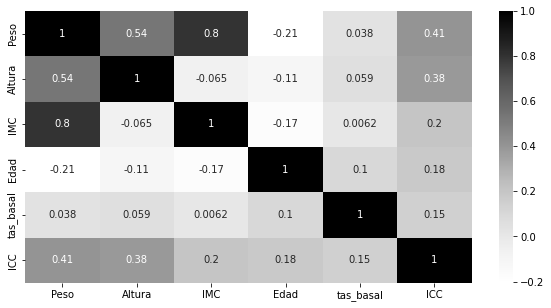

In [66]:
sns.heatmap(tesis_basal[numerical].corr(), annot=True, cmap="Greys")

### Variancia homogenea

<AxesSubplot:xlabel='tpo_programa', ylabel='TAS'>

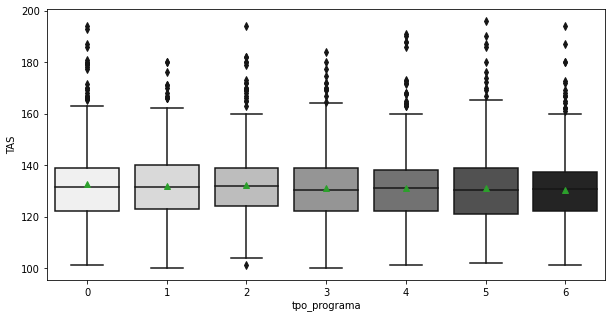

In [67]:
sns.boxplot(x=tesis["tpo_programa"], y=tesis["TAS"], showmeans=True, palette="Greys")

### Variograma

In [68]:
from statistics import mean, median, mode

for cat in categorical:
    tesis[cat] = tesis[cat].fillna(mode(tesis[cat]))

for num in numerical:
    tesis[num] = tesis[num].fillna(np.mean(tesis[num]))

In [69]:
from sklearn.preprocessing import PolynomialFeatures

columns = tesis.columns

poly = PolynomialFeatures(interaction_only=True)
tesis = poly.fit_transform(tesis)
new_columns = poly.get_feature_names(columns)
new_columns = [column.replace(' ', '*') for column in new_columns]

tesis = pd.DataFrame(tesis, columns=new_columns)

tesis["Intercept"] = 1

In [70]:
fixed_effects = ["Intercept", "Sexo", "Edad", "DBT", "Fuma", "IMC", "ICC", "tas_basal", "tpo_programa",
                 "tpo_programa*Sexo", "tpo_programa*Edad", "tpo_programa*DBT", "tpo_programa*Fuma", "tpo_programa*IMC", "tpo_programa*ICC", "tpo_programa*tas_basal", "tpo_programa*Adherencia"]

mixed = MixedLM(endog=tesis["TAS"], exog=tesis[fixed_effects], exog_re=tesis[["Intercept", "tpo_programa"]], groups=tesis["idPaciente"]).fit(reml=True)

In [71]:
import statsmodels.api as sm
# fixed_effects = ["Intercept", "tpo_programa"]
mixed = sm.OLS(tesis["TAS"], tesis[fixed_effects]).fit()

In [72]:
def variograma(id, x, y):
    """
    id = (nobs x 1) vector con los id
    y = (nobs x 1) vector respuesta (residuos)
    x = (nobs x 1) vector de covariables (tiempo)
    
    RETURN: delta.y = vec( 0.5*(y_ij - y_ik)^2 )
            delta.x = vec( abs( x_ij - x_ik ) )
    """
    uid = id.unique()
    m = len(uid)
    delta_y = []
    delta_x = []
    did = []
    for i in range(m):
        yi = y[id == uid[i]]
        xi = x[id == uid[i]]
        n = len(yi)
        expand_j = [i for i in range(n)]*n
        expand_k = np.repeat([i for i in range(n)], n)
        keep = expand_j > expand_k
        if keep.sum() > 0:
            expand_j = [j for j, b in zip(expand_j, keep) if b]
            expand_k = [k for k, b in zip(expand_k, keep) if b]
            delta_yi = 0.5*(np.array(yi.iloc[expand_j]) - np.array(yi.iloc[expand_k]))**2
            delta_xi = abs(np.array(xi.iloc[expand_j]) - np.array(xi.iloc[expand_k]))
            didi = np.repeat(uid[i], len(delta_yi))
            delta_y.extend(list(delta_yi))
            delta_x.extend(list(delta_xi))
            did.extend(list(didi))
    return did, delta_x, delta_y

In [73]:
did, delta_x, delta_y = variograma(tesis["idPaciente"], tesis["tpo_programa"], mixed.resid)

In [74]:
import rpy2.robjects as robjects

r_x = robjects.FloatVector(delta_x)
r_y = robjects.FloatVector(delta_y)

r_smooth_spline = robjects.r["smooth.spline"]

spline = r_smooth_spline( r_x, r_y, df=5 )

ModuleNotFoundError: No module named 'rpy2'

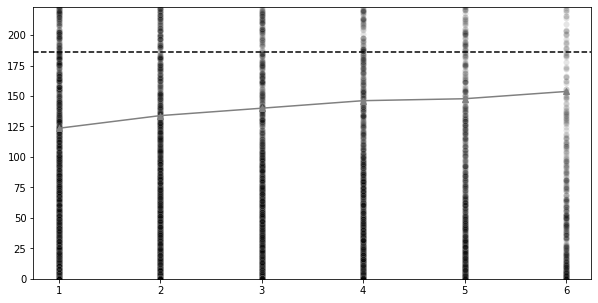

In [ ]:
var = np.var(mixed.resid)
fig, ax = plt.subplots(1,1)
ax.set_prop_cycle(monochrome)
scat = sns.scatterplot(delta_x, delta_y, alpha=0.1, palette="Greys")
plt.axhline(var, color="black", linestyle="--")
scat.set(ylim=(0, 1.2*var))
plt.plot(spline[0], spline[1], color="grey")
plt.show()

# Variograma R

In [ ]:
cd4 = pd.read_excel("Datos/cd4.xls")

In [ ]:
!pip install xlrd

You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [ ]:
cd4

,id,tiempo,CD4,edad,cigarrillos,drogas,parejas,CESD
0,10002,-0.741958,548,6.57,0,0,5,8
1,10002,-0.246407,893,6.57,0,1,5,2
2,10002,0.243669,657,6.57,0,1,5,-1
3,10005,-2.729637,464,6.95,0,1,5,4
4,10005,-2.250513,845,6.95,0,1,5,-4
...,...,...,...,...,...,...,...,...
2371,41844,0.238193,570,-5.04,4,1,0,10
2372,41844,0.772074,826,-5.04,4,1,-4,4
2373,41844,1.538672,983,-5.04,4,1,-4,8
2374,41844,2.056126,517,-5.04,4,0,-3,9


In [ ]:
cd4["tiempo2"] = cd4["tiempo"]*cd4["tiempo"]
cd4["tiempo3"] = cd4["tiempo"]*cd4["tiempo"]*cd4["tiempo"]
cd4["tiempo_edad"] = cd4["tiempo"]*cd4["edad"]
cd4["tiempo2_edad"] = cd4["tiempo2"]*cd4["edad"]
cd4["tiempo3_edad"] = cd4["tiempo3"]*cd4["edad"]
cd4["intercept"] = 1

In [ ]:
mixed = MixedLM(endog=cd4["CD4"], exog=cd4[["intercept", "edad", "tiempo", "tiempo_edad", "tiempo2", "tiempo2_edad", "tiempo3", "tiempo3_edad"]], groups=cd4["id"]).fit()

In [ ]:
import statsmodels.api as sm
model = sm.OLS(cd4["CD4"], cd4[["intercept", "edad", "tiempo", "tiempo_edad", "tiempo2", "tiempo2_edad", "tiempo3", "tiempo3_edad"]]).fit()

In [ ]:
def variograma(id, x, y):
    """
    id = (nobs x 1) vector con los id
    y = (nobs x 1) vector respuesta (residuos)
    x = (nobs x 1) vector de covariables (tiempo)
    
    RETURN: delta.y = vec( 0.5*(y_ij - y_ik)^2 )
            delta.x = vec( abs( x_ij - x_ik ) )
    """
    uid = id.unique()
    m = len(uid)
    delta_y = []
    delta_x = []
    did = []
    for i in range(m):
        yi = y[id == uid[i]]
        xi = x[id == uid[i]]
        n = len(yi)
        expand_j = [i for i in range(n)]*n
        expand_k = np.repeat([i for i in range(n)], n)
        keep = expand_j > expand_k
        if keep.sum() > 0:
            expand_j = [j for j, b in zip(expand_j, keep) if b]
            expand_k = [k for k, b in zip(expand_k, keep) if b]
            delta_yi = 0.5*(np.array(yi.iloc[expand_j]) - np.array(yi.iloc[expand_k]))**2
            delta_xi = abs(np.array(xi.iloc[expand_j]) - np.array(xi.iloc[expand_k]))
            didi = np.repeat(uid[i], len(delta_yi))
            delta_y.extend(list(delta_yi))
            delta_x.extend(list(delta_xi))
            did.extend(list(didi))
    return did, delta_x, delta_y

In [ ]:
did, delta_x, delta_y = variograma(cd4["id"], cd4["tiempo"], mixed.resid)

In [ ]:
import rpy2.robjects as robjects

r_x = robjects.FloatVector(delta_x)
r_y = robjects.FloatVector(delta_y)

r_smooth_spline = robjects.r["smooth.spline"]

spline = r_smooth_spline( r_x, r_y, df=5 )

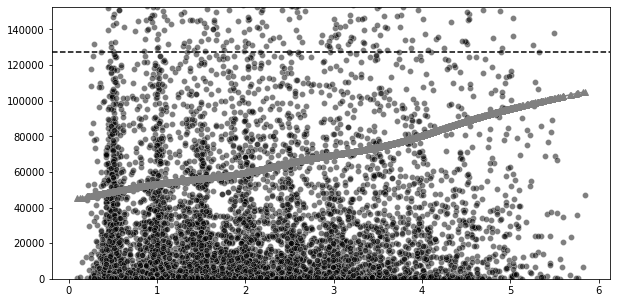

In [ ]:
var = np.var(model.resid)
fig, ax = plt.subplots(1,1)
ax.set_prop_cycle(monochrome)
scat = sns.scatterplot(delta_x, delta_y, alpha=0.5)
plt.axhline(var, color="black", linestyle="--")
scat.set(ylim=(0, 1.2*var))
plt.plot(spline[0], spline[1], color="grey")
plt.show()